In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import chart_studio.plotly as py
from urllib.request import urlopen
import plotly.express as px
import json
import itertools
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
scenarios = """/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/age_data/VDH_age_vaccinations_per_100K_scenario_high_boost.csv
/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/age_data/VDH_age_vaccinations_per_100K_scenario_high_boost_OptVax.csv
/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/age_data/VDH_age_vaccinations_per_100K_scenario_low_boost.csv
/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/age_data/VDH_age_vaccinations_per_100K_scenario_low_boost_OptVax.csv""".split("\n")
scenarios = [i.split("scenario_")[-1].split(".")[0] for i in scenarios]

In [3]:
from matplotlib import pyplot as plt

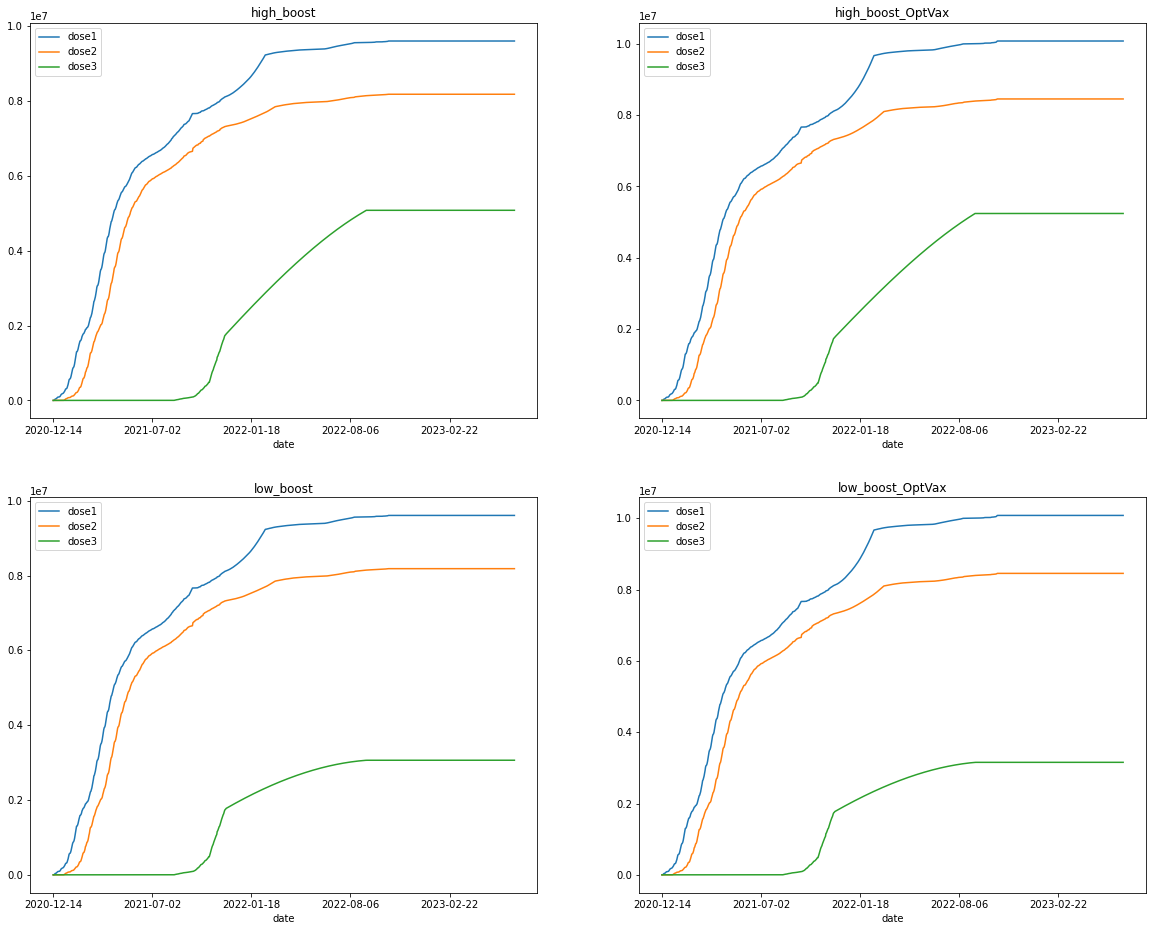

In [5]:
fig, axs = plt.subplots(figsize=(20,16), ncols= 2, nrows=2)
for ix, scenario in enumerate(scenarios):
    ax = axs[ix//2, ix%2]
    vax = pd.read_csv(f"/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/age_data/VDH_age_vaccinations_per_100K_scenario_{scenario}.csv")
    vax = vax.groupby("date").sum().drop(columns="fips")
    vax.columns = [i.split("_")[0] for i in vax.columns]
    vax.groupby(vax.columns, axis=1).sum().drop(columns=["doses"]).plot(ax=ax)
    ax.set_title(scenario)
    
plt.savefig("../plots/VDH_vax_summaries.png", dpi=100, facecolor="white", bbox_inches="tight")

In [2]:
fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["CENSUS2010POP"].to_dict()

fips_to_dist = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_spread-modeling/US_National/VA/PatchSim/data/VA_Gov_Regions.csv", dtype={"GEOID":str, "fips":str})
name_mapper = {s:s for s in fips_to_dist["VDH_Dist"].unique()}
name_mapper["Chikahominy"] = "Chickahominy"
name_mapper["Cumberland"] = "Cumberland Plateau"
name_mapper["Roanoke City"] = "Roanoke"
name_mapper["Pittsylvania Danville"] = "Pittsylvania-Danville"
for key in set(name_mapper.values()) - set(name_mapper.keys()):
    name_mapper[key] = key
fips_to_dist["VDH_Dist"] = fips_to_dist["VDH_Dist"].apply(lambda row: name_mapper[row])
fips_to_dist = dict(zip(fips_to_dist.GEOID.values, fips_to_dist.VDH_Dist.values))

dist_to_fips = {dist:[i for i,d in fips_to_dist.items() if d == dist] for dist in fips_to_dist.values()}
dist_to_pop = {dist:sum([fips_to_pop[i] for i in dist_to_fips[dist]]) for dist in dist_to_fips.keys()}

In [3]:
"""Should try to combine the fips into the districts with something like https://stackoverflow.com/questions/34325030/merging-two-geojson-polygons-in-python"""

'Should try to combine the fips into the districts with something like https://stackoverflow.com/questions/34325030/merging-two-geojson-polygons-in-python'

In [4]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
counties["features"] = [i for i in counties["features"] if i["properties"]["STATE"] == "51"]

In [5]:
gisaid = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date"], dtype={"state":str})
gisaid_dates = gisaid.groupby("variant").date.min().to_dict()
va_gisaid = gisaid[gisaid.state == "51"]
va_gisaid_dates = va_gisaid.groupby("variant").date.min().to_dict()

In [6]:
gisaid_dates

{'AY.3': Timestamp('2020-08-12 00:00:00'),
 'AY.4': Timestamp('2020-09-09 00:00:00'),
 'AY.other': Timestamp('2020-07-13 00:00:00'),
 'B.1.1.7': Timestamp('2020-03-01 00:00:00'),
 'B.1.351': Timestamp('2020-05-07 00:00:00'),
 'B.1.427': Timestamp('2020-04-11 00:00:00'),
 'B.1.429': Timestamp('2020-03-11 00:00:00'),
 'B.1.526': Timestamp('2020-04-21 00:00:00'),
 'B.1.617.1': Timestamp('2021-02-25 00:00:00'),
 'B.1.617.2': Timestamp('2020-08-31 00:00:00'),
 'B.1.621': Timestamp('2021-01-01 00:00:00'),
 'C.37': Timestamp('2021-01-20 00:00:00'),
 'P.1': Timestamp('2020-04-07 00:00:00'),
 'other': Timestamp('2020-02-27 00:00:00')}

In [6]:
variants = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_opioids/VDH-UVA-DSA-COVID-19-Variant.tsv", sep="\t") #, parse_dates=["report_date", "date"], dtype={"fips":str})
print(variants.columns)
variants = variants.iloc[:, [3, 6, 8, 11, 13, 14, 15, 21]]
variants.columns = ["variant", "age", "count", "district", "fips", "outbreak", "date", "seqid"]
variants.date = pd.to_datetime(variants.date)
variants.fips = variants.fips.astype(str)
variants = variants.sort_values("date")
variants = variants.dropna(subset=["date"])


Index(['COVID_19_VARIANT', 'Specimen_Id ', 'Report Date', 'VARIANT_CLEAN',
       'Vaccine Age group', 'Age Group', 'Patient Age in Years',
       'Tiered Race Ethnicity', 'Variant Count', 'Death Count',
       'Hospitalized Count', 'HealthDistrict', 'PATIENT_CURRENT_SEX',
       'PATIENT_COUNTY', 'OUTBREAK_IND', 'Event_Dt_Upd', 'WEEK_END_DT_CDC',
       'Lab_Report_Dt', 'Testing_Lab_Accession_Number',
       'Reporting_Facility_Name', 'Ordering_Facility_Name',
       'DCLS Sequencing ID'],
      dtype='object')


In [12]:
variants[variants.variant == "B.1.1.7"].sort_values("date").head()

,variant,age,count,district,fips,outbreak,date,seqid
0,B.1.1.7,69,1,Portsmouth,51740,N,2021-04-09,VA-DCLS-5118
78,B.1.1.7,77,1,Henrico,51087,N,2021-04-12,VA-DCLS-5226
25,B.1.1.7,68,1,West Piedmont,51067,N,2021-04-18,VA-DCLS-5154
97,B.1.1.7,29,1,Henrico,51087,Y,2021-04-22,VA-DCLS-5248
234,B.1.1.7,49,1,Alleghany,51161,N,2021-04-24,VA-DCLS-5414


In [13]:
variants[variants.variant == "B.1.617.2"].sort_values("date").head()

,variant,age,count,district,fips,outbreak,date,seqid
803,B.1.617.2,41,1,Rappahannock,51179,NaN,2020-07-19,VA-DCLS-6133
2664,B.1.617.2,28,1,Richmond,51760,N,2020-08-20,VA-DCLS-8374
3338,B.1.617.2,83,1,Rappahannock,51179,Y,2020-09-11,VA-DCLS-9306
2400,B.1.617.2,83,1,Rappahannock,51179,Y,2020-09-11,VA-DCLS-8064
904,B.1.617.2,2,1,Prince William,51153,UNK,2020-09-24,VA-DCLS-6257


In [23]:
# print(variants.columns)
# variants = variants.rename(columns={"covid_19_variant":"variant", "healthdistrict":"district", "testing_lab_accession_number":"accession", "patient_age_in_years":"age"})
# variants.variant = variants.variant_clean
# print(variants.head())
# variants = variants[["report_date", "date", "variant", "age", "district", "specimen_id", "accession", "patient_county"]].sort_values("date")
# variants.date = variants.date.astype(str).apply(lambda row: row.replace("2012", "2021"))

In [24]:
variants.groupby("date").count()["variant"]

date
2020-07-19     1
2020-08-20     1
2020-09-11     2
2020-09-24     2
2020-09-27     2
              ..
2021-09-28     4
2021-09-29    12
2021-09-30     3
2021-10-01     1
2021-11-02     1
Name: variant, Length: 174, dtype: int64

In [26]:
variants[variants.fips.isin(["51540", "51003"])].groupby("date").count()["variant"].index

DatetimeIndex(['2021-05-17', '2021-06-12', '2021-06-25', '2021-07-01',
               '2021-07-15', '2021-07-18', '2021-07-23', '2021-07-24',
               '2021-08-03', '2021-08-04', '2021-08-14', '2021-08-16',
               '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20',
               '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26',
               '2021-08-27', '2021-09-03', '2021-09-09', '2021-09-10',
               '2021-09-12', '2021-09-17', '2021-09-24'],
              dtype='datetime64[ns]', name='date', freq=None)

Text(0.5, 1.0, 'Count of VA Sequences Coming from Locations')

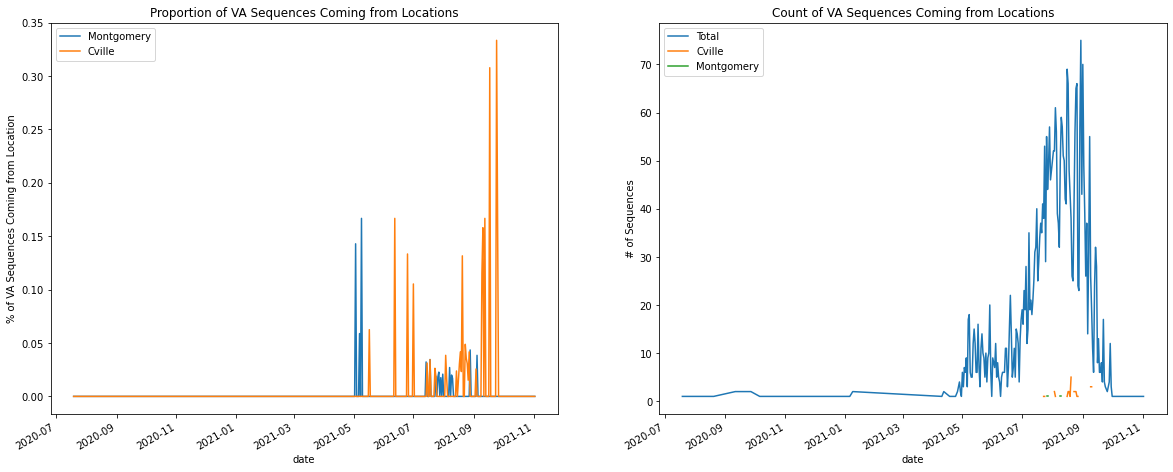

In [27]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2)

ax=axs[0]
(variants[variants.fips == "51121"].groupby("date").count()["variant"] / variants.groupby("date").count()["variant"]).fillna(0).plot(label="Montgomery", ax=ax)
(variants[variants.fips.isin(["51540", "51003"])].groupby("date").count()["variant"] / variants.groupby("date").count()["variant"]).fillna(0).plot(label="Cville", ax=ax)
ax.legend()
ax.set_ylabel("% of VA Sequences Coming from Location")
ax.set_title("Proportion of VA Sequences Coming from Locations")

ax=axs[1]
counts = variants.groupby("date").count()[["variant"]].rename(columns={"variant":"Total"})
counts["Cville"] = variants[variants.fips.isin(["51540", "51003"])].groupby("date").count()["variant"]
counts["Montgomery"] = variants[variants.fips == "51121"].groupby("date").count()["variant"]
counts.plot(ax=ax)
ax.legend()
ax.set_ylabel("# of Sequences")
ax.set_title("Count of VA Sequences Coming from Locations")
# plt.savefig("../plots/sample_prop_and_count_virginia_montgomery_cville_summary.png", dpi=100, facecolor="white", bbox_inches="tight")

In [ ]:
variants[variants.fips == "51121"].groupby("date").count()[["variant"]].rename(columns={"variant":"Montgomery"})

In [ ]:
first_dates = variants.copy()
first_dates = first_dates[first_dates.variant.isin(["B.1.1.7", "B.1.617.2"])]
first_dates["gisaid_date_detected"] = first_dates.variant.apply(lambda row: va_gisaid_dates[row])

first_dates = first_dates[first_dates.date >= first_dates.gisaid_date_detected]
first_dates.date = pd.to_datetime(first_dates.date)
first_dates = first_dates.groupby(["district", "variant"]).date.min().reset_index().pivot(index="district", columns="variant", values="date")[["B.1.1.7", "B.1.617.2"]]
for col in first_dates: #.info() 
    first_dates[col] = pd.to_datetime(first_dates[col])
    
# first_dates["B.1.1.7"] = first_dates["B.1.1.7"].apply(lambda row: (row - va_gisaid_dates["B.1.1.7"]).days)
min_alpha = first_dates["B.1.1.7"].min()
first_dates["B.1.1.7"] = first_dates["B.1.1.7"].apply(lambda row: (row - min_alpha).days)
# first_dates["B.1.617.2"] = first_dates["B.1.617.2"].apply(lambda row: (row - va_gisaid_dates["B.1.617.2"]).days)
min_delta = first_dates["B.1.617.2"].min()
first_dates["B.1.617.2"] = first_dates["B.1.617.2"].apply(lambda row: (row - min_delta).days)
first_dates = first_dates.melt(ignore_index=False).reset_index()

fig, ax = plt.subplots(figsize=(12,10))

sns.barplot(x="district", y="value", hue="variant", data=first_dates, ax=ax)
ax.tick_params(axis="x", labelrotation=80)
ax.set_title(f"B.1.1.7 & B.1.617.2 Detection Day Relative to First in VDH Data\nAlpha: {str(min_alpha).split()[0]}, Delta: {str(min_delta).split()[0]}")
# ax.set_title(f"B.1.1.7 & B.1.617.2 Detection Day Relative to First in VDH Data\nAlpha: {str(va_gisaid_dates['B.1.1.7']).split()[0]}, Delta: {str(va_gisaid_dates['B.1.617.2']).split()[0]}")
ax.set_ylabel("Days Since First Detection in VDH Data")
plt.savefig("../plots/alpha_delta_virginia_district_detection_time_relative_to_first_in_vdh.png", dpi=100, facecolor="white", bbox_inches="tight")

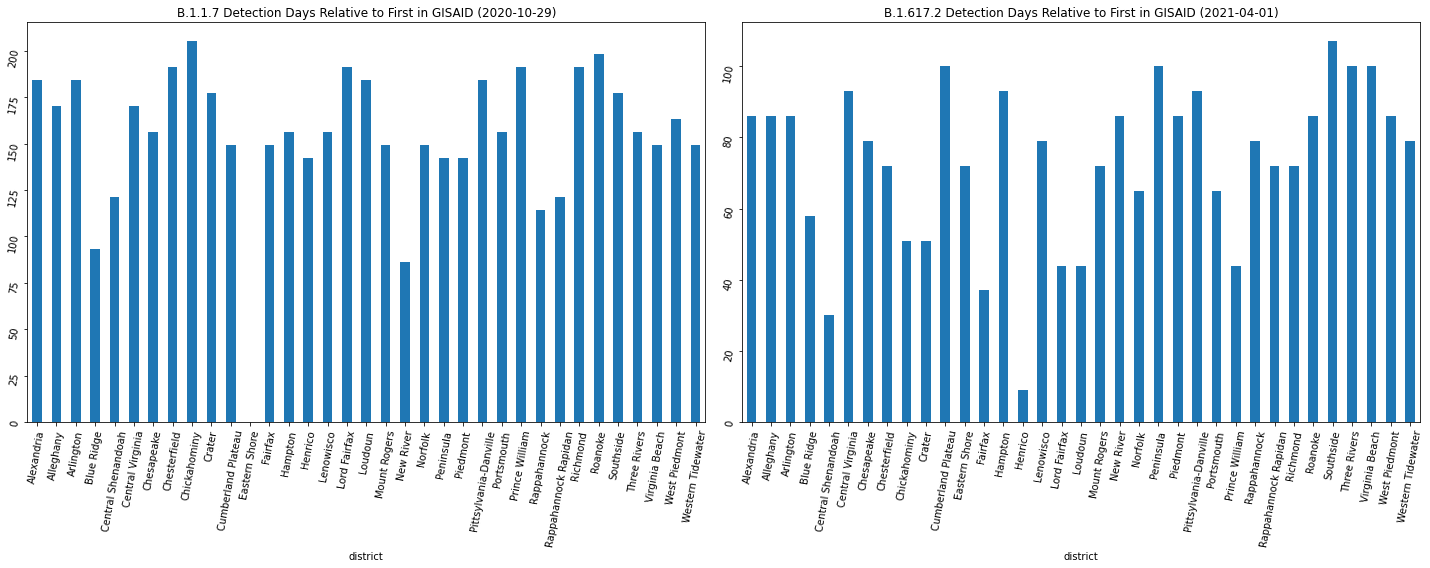

In [145]:

ax=axs[0]
first_dates["B.1.1.7"].sort_index().plot(kind="bar", ax=ax)



ax=axs[1]
first_dates["B.1.617.2"].sort_index().plot(kind="bar", ax=ax)
ax.tick_params(labelrotation=80)
ax.set_title(f"B.1.617.2 Detection Days Relative to First in GISAID ({str(va_gisaid_dates['B.1.617.2']).split()[0]})")

plt.tight_layout()
plt.savefig("../plots/alpha_delta_virginia_district_detection_time_relative_to_first_in_gisaid.png", dpi=100, facecolor="white", bbox_inches="tight")

In [ ]:
def get_va_df():
    va_df = pd.read_csv('/project/biocomplexity/COVID-19_commons/2019-nCoV_spread-modeling/US_National/VA/PatchSim/data/vdh_subplot_grid.csv')

    name_mapper = {s:s for s in va_df["VDH_Dist"].unique()}
    name_mapper["Chikahominy"] = "Chickahominy"
    name_mapper["Cumberland"] = "Cumberland Plateau"
    name_mapper["Roanoke City"] = "Roanoke"
    name_mapper["Pittsylvania Danville"] = "Pittsylvania-Danville"
    va_df
    
    return va_df, name_mapper

va_df, name_mapper = get_va_df()
R = va_df.Row.max()+1
C = va_df.Column.max()+1
n_weeks_date = np.datetime64(datetime.datetime.now().strftime("%Y-%m-%d")) - np.timedelta64(7*n_weeks, "D")    

#Allows you to assign arbitrary rectangular set of "panels" to use for each subplot
fig = plt.figure(figsize=(60,24)) 
gs = fig.add_gridspec(R,C) #,sharex=True)

# va_ax = fig.add_subplot(gs[1:3, C-2:])

# va_ax.set_title("Virginia", fontsize=24)
# va_ax.set_ylabel("% of Cases", fontsize=20)


for r in range(R):
    for c in range(C):
        mask = (va_df.Row==r)&(va_df.Column==c)
        if len(va_df[mask])==0:
            pass
#                     ax.set_visible(False)
        else:
            ax = fig.add_subplot(gs[r,c]) #axarr[r][c]

            s = va_df[mask]['VDH_Dist'].values[0]
            h = va_df[mask]['VDH_Region'].values[0]
            district = s

            ax.set_title(s, fontsize=24)


In [65]:
# variants = pd.read_csv("../data/VDH-COVID-19-PublicUseDataset-Variants_of_Concern.csv", parse_dates=["Report Date"]).rename(columns={"Report Date":"date"})
# variants["Health District"] = variants["Health District"].apply(lambda row: name_mapper[row])
# variants = variants.pivot(index=["date", "Variant"], columns="Health District", values="Number of Infections").astype(float)
# # variants = variants.rename(columns={"Cumberland Plateau":"Cumberland", 'Pittsylvania-Danville':'Pittsylvania Danville'})
# for col in variants:
#     dist_pop = dist_to_pop[col]
#     for fips in dist_to_fips[col]:
#         fips_ratio = (fips_to_pop[fips] / dist_pop)
#         variants[fips] = fips_ratio * variants[col]

# variant_dict = {}
# for variant, df in variants[sorted(fips_to_dist.keys())].reset_index().set_index("date").sort_index().groupby("Variant"):
#     variant_dict[variant] = df.drop(columns=["Variant"])

In [67]:
var = ("B.1.1.7", "Alpha")
variant = var[0]
variant_name = var[1]

if resolve == "county":
    vdh_delta_variants = variants[variants.variant == variant][["date", "variant", "fips"]]
    vdh_delta_variants = vdh_delta_variants.dropna().groupby(["date", "fips"]).count().reset_index().rename(columns={"variant":"count", "fips":"fips"})
#         not_zero = vdh_delta_variants[vdh_delta_variants["count"] > 0].pivot(index="date", columns="fips", values="count")
#         results = sorted([(variant_name, i,not_zero[i].dropna().index.min(),not_zero[i].dropna().iloc[0]) for i in not_zero], key = lambda row: row[2])
#         for i in results[:10]:
#             print(i)
#         vdh_delta_variants = vdh_delta_variants.pivot(index="date", columns="fips", values="count").fillna(0).melt(ignore_index=False).reset_index().replace(0, np.nan)

else:
    vdh_delta_variants = variants[variants.variant == variant][["date", "variant", "district"]]
    vdh_delta_variants = vdh_delta_variants.dropna().groupby(["date", "district"]).count().reset_index().rename(columns={"variant":"count", "district":"fips"})
#         not_zero = vdh_delta_variants[vdh_delta_variants["count"] > 0].pivot(index="date", columns="fips", values="count")
#         results = sorted([(variant_name, i,not_zero[i].dropna().index.min(),not_zero[i].dropna().iloc[0]) for i in not_zero], key = lambda row: row[2])
#         for i in results[:10]:
#             print(i)
    vdh_delta_variants.fips = vdh_delta_variants.fips.apply(lambda row: dist_to_fips[row])
    vdh_delta_variants = vdh_delta_variants.explode("fips")
    
    
vdh_delta_variants = vdh_delta_variants.pivot(index="date", columns="fips", values="count")
vdh_delta_variants.index = pd.to_datetime(vdh_delta_variants.index)

vdh_delta_variants = vdh_delta_variants.reindex(pd.date_range(vdh_delta_variants.index.min(), vdh_delta_variants.index.max(), freq="7D")).fillna(0) #.head()

if weeks_since_gisaid_detection:
    vdh_delta_variants = vdh_delta_variants.loc[va_gisaid_dates[variant]:]
    date_sum = pd.DataFrame(vdh_delta_variants.sum(axis=1))
    first_detection_date_vdh = date_sum[date_sum > 0].dropna().index.min()
    vdh_delta_variants = vdh_delta_variants.loc[first_detection_date_vdh:].reset_index(drop=True)
    vdh_delta_variants = vdh_delta_variants.cumsum()

# print(first_detection_date_vdh)
# x = vdh_delta_variants.loc[first_detection_date_vdh]
# x[x > 0]
x = vdh_delta_variants.iloc[0]
x[x>0]

fips
51121    1.0
Name: 0, dtype: float64

In [ ]:
#     import pdb; pdb.set_trace()
#     vdh_delta_variants = vdh_delta_variants.pivot(index="date", columns="fips", values="count").fillna(0).melt(ignore_index=False).reset_index().replace(0, np.nan)

#     print(vdh_delta_variants.head())

#     vdh_delta_variants = vdh_delta_variants.melt(ignore_index=False).reset_index().replace(0, np.nan).rename(columns={"index":"date"})
#     vdh_delta_variants.date = vdh_delta_variants.date.astype(str)
#     print(vdh_delta_variants.head())



vdh_delta_variants["variant"] = variant_name

In [7]:
variant_info = [("B.1.1.7", "Alpha"), ("B.1.617.2", "Delta")]
variant_datas = []
resolve = "county"
weeks_since_gisaid_detection = True
variant_first_detections = {}
names = []
for var in variant_info:
    variant = var[0]
    variant_name = var[1]
    
    if resolve == "county":
        vdh_delta_variants = variants[variants.variant == variant][["date", "variant", "fips"]]
        vdh_delta_variants = vdh_delta_variants.dropna().groupby(["date", "fips"]).count().reset_index().rename(columns={"variant":"count", "fips":"fips"})
#         not_zero = vdh_delta_variants[vdh_delta_variants["count"] > 0].pivot(index="date", columns="fips", values="count")
#         results = sorted([(variant_name, i,not_zero[i].dropna().index.min(),not_zero[i].dropna().iloc[0]) for i in not_zero], key = lambda row: row[2])
#         for i in results[:10]:
#             print(i)
#         vdh_delta_variants = vdh_delta_variants.pivot(index="date", columns="fips", values="count").fillna(0).melt(ignore_index=False).reset_index().replace(0, np.nan)

    else:
        vdh_delta_variants = variants[variants.variant == variant][["date", "variant", "district"]]
        vdh_delta_variants = vdh_delta_variants.dropna().groupby(["date", "district"]).count().reset_index().rename(columns={"variant":"count", "district":"fips"})
#         not_zero = vdh_delta_variants[vdh_delta_variants["count"] > 0].pivot(index="date", columns="fips", values="count")
#         results = sorted([(variant_name, i,not_zero[i].dropna().index.min(),not_zero[i].dropna().iloc[0]) for i in not_zero], key = lambda row: row[2])
#         for i in results[:10]:
#             print(i)
        vdh_delta_variants.fips = vdh_delta_variants.fips.apply(lambda row: dist_to_fips[row])
        vdh_delta_variants = vdh_delta_variants.explode("fips")
#     import pdb; pdb.set_trace()
#     vdh_delta_variants = vdh_delta_variants.pivot(index="date", columns="fips", values="count").fillna(0).melt(ignore_index=False).reset_index().replace(0, np.nan)
    vdh_delta_variants = vdh_delta_variants.pivot(index="date", columns="fips", values="count")
    vdh_delta_variants.index = pd.to_datetime(vdh_delta_variants.index)
#     print(vdh_delta_variants.head())

#     vdh_delta_variants = vdh_delta_variants.reindex(pd.date_range(vdh_delta_variants.index.min(), vdh_delta_variants.index.max(), freq="7D")).fillna(0) #.head()
    vdh_delta_variants = vdh_delta_variants.reindex(pd.date_range(vdh_delta_variants.index.min(), vdh_delta_variants.index.max())).fillna(0) #.head()
#     vdh_delta_variants = vdh_delta_variants.melt(ignore_index=False).reset_index().replace(0, np.nan).rename(columns={"index":"date"})
#     vdh_delta_variants.date = vdh_delta_variants.date.astype(str)
#     print(vdh_delta_variants.head())
    if weeks_since_gisaid_detection:
#         vdh_delta_variants = vdh_delta_variants.loc[va_gisaid_dates[variant]:]
        date_sum = pd.DataFrame(vdh_delta_variants.sum(axis=1))
        first_detection_date_vdh = date_sum[date_sum > 0].dropna().index.min()
        variant_first_detections[variant] = first_detection_date_vdh
        vdh_delta_variants = vdh_delta_variants.loc[first_detection_date_vdh:].reset_index(drop=True)
        vdh_delta_variants = vdh_delta_variants.cumsum()

    vdh_delta_variants["variant"] = variant_name + ": " + str(first_detection_date_vdh).split()[0]
    names.append(variant_name + ": " + str(first_detection_date_vdh).split()[0])

    variant_datas.append(vdh_delta_variants)

variant_datas = pd.concat(variant_datas)
if weeks_since_gisaid_detection:
#     print(variant_datas.head())
    variant_datas = variant_datas.reset_index().set_index(["variant","index"]).reindex(list(itertools.product(names, range(variant_datas.index.min(), variant_datas.index.max()))))
    variant_datas = variant_datas.reset_index().rename(columns={"index":"days_since_detection"}).set_index("days_since_detection")
    variants_names = variant_datas.variant
    variant_datas = variant_datas.groupby(["variant"]).ffill()
    variant_datas["variant"] = variants_names
    variant_datas = variant_datas.melt(ignore_index=False, id_vars=["variant"])
#     variant_datas = variant_datas.replace(0, np.nan).reset_index() #.head()
    variant_datas = variant_datas.reset_index() #.ffill()
    variant_datas.value = variant_datas.value.replace(0, np.nan) #.head()
#     variant_datas.weeks_since_detection = variant_datas.weeks_since_detection.astype(str)
else:
#     variant_datas = variant_datas.reset_index().set_index(["variant","index"]).reindex(list(itertools.product(["Delta", "Alpha"], pd.date_range(variant_datas.index.min(), variant_datas.index.max(), freq="7D"))))
    variant_datas = variant_datas.reset_index().set_index(["variant","index"]).reindex(list(itertools.product(names, pd.date_range(variant_datas.index.min()))))
    variant_datas = variant_datas.reset_index().rename(columns={"index":"date"}).set_index("date").melt(ignore_index=False, id_vars=["variant"])
    variant_datas = variant_datas.replace(0, np.nan).reset_index() #.head()
    variant_datas.date = variant_datas.date.astype(str)
    
    
variant_datas #[variant_datas.value == 386] #.groupby("variant").max() #[variant_datas.variant == "Alpha"]

,days_since_detection,variant,fips,value
0,0,Alpha: 2021-04-09,51003,NaN
1,1,Alpha: 2021-04-09,51003,NaN
2,2,Alpha: 2021-04-09,51003,NaN
3,3,Alpha: 2021-04-09,51003,NaN
4,4,Alpha: 2021-04-09,51003,NaN
...,...,...,...,...
115861,466,Delta: 2020-07-19,51840,33.0
115862,467,Delta: 2020-07-19,51840,33.0
115863,468,Delta: 2020-07-19,51840,33.0
115864,469,Delta: 2020-07-19,51840,33.0


In [11]:
print("B.1.1.7", va_gisaid_dates["B.1.1.7"])
print("B.1.617.2", va_gisaid_dates["B.1.617.2"])

B.1.1.7 2020-10-29 00:00:00
B.1.617.2 2021-04-01 00:00:00


In [9]:
variant_first_detections

{'B.1.1.7': Timestamp('2021-04-09 00:00:00'),
 'B.1.617.2': Timestamp('2020-07-19 00:00:00')}

In [15]:
variants[(variants.variant == "B.1.617.2") & (variants.date >= va_gisaid_dates["B.1.617.2"])].date.min()

Timestamp('2021-05-02 00:00:00')

In [93]:
str(variant_first_detections["B.1.1.7"]).split()[0]

'2021-01-23'

In [30]:
# variants[(variants.variant == "B.1.1.7") & (variants.date >= str(variant_first_detections["B.1.1.7"]).split()[0])].head(10)
print(str(gisaid_dates["B.1.1.7"]).split()[0])
print(str(va_gisaid_dates["B.1.1.7"]).split()[0])
variants[(variants.variant == "B.1.1.7") & (variants.date < str(va_gisaid_dates["B.1.1.7"]).split()[0])]

2020-03-01
2020-10-29


,variant,age,count,district,fips,outbreak,date,seqid


In [31]:
print(str(gisaid_dates["B.1.617.2"]).split()[0])
print(str(va_gisaid_dates["B.1.617.2"]).split()[0])
variants[(variants.variant == "B.1.617.2") & (variants.date <= str(va_gisaid_dates["B.1.617.2"]).split()[0])]

2020-08-31
2021-04-01


,variant,age,count,district,fips,outbreak,date,seqid
803,B.1.617.2,41,1,Rappahannock,51179,NaN,2020-07-19,VA-DCLS-6133
2664,B.1.617.2,28,1,Richmond,51760,N,2020-08-20,VA-DCLS-8374
3338,B.1.617.2,83,1,Rappahannock,51179,Y,2020-09-11,VA-DCLS-9306
2400,B.1.617.2,83,1,Rappahannock,51179,Y,2020-09-11,VA-DCLS-8064
904,B.1.617.2,2,1,Prince William,51153,UNK,2020-09-24,VA-DCLS-6257
1096,B.1.617.2,2,1,Prince William,51153,UNK,2020-09-24,VA-DCLS-6484
2451,B.1.617.2,31,1,Loudoun,51107,N,2020-09-27,VA-DCLS-8123
2088,B.1.617.2,31,1,Loudoun,51107,N,2020-09-27,VA-DCLS-7710
2319,B.1.617.2,37,1,Loudoun,51107,NaN,2020-10-06,VA-DCLS-7976
1714,B.1.617.2,29,1,Arlington,51013,N,2020-12-27,VA-DCLS-7263


In [48]:
print(variant_first_detections["B.1.1.7"])
variants[(variants.variant == "B.1.1.7") & (variants.date >= str(variant_first_detections["B.1.1.7"]).split()[0])].head(10)


2021-04-09 00:00:00


,variant,age,count,district,fips,outbreak,date,seqid
0,B.1.1.7,69,1,Portsmouth,51740,N,2021-04-09,VA-DCLS-5118
78,B.1.1.7,77,1,Henrico,51087,N,2021-04-12,VA-DCLS-5226
25,B.1.1.7,68,1,West Piedmont,51067,N,2021-04-18,VA-DCLS-5154
97,B.1.1.7,29,1,Henrico,51087,Y,2021-04-22,VA-DCLS-5248
234,B.1.1.7,49,1,Alleghany,51161,N,2021-04-24,VA-DCLS-5414
1,B.1.1.7,0,1,Henrico,51087,N,2021-04-26,VA-DCLS-5119
244,B.1.1.7,49,1,Alexandria,51510,UNK,2021-04-26,VA-DCLS-5425
77,B.1.1.7,73,1,Central Shenandoah,51091,N,2021-04-27,VA-DCLS-5225
51,B.1.1.7,35,1,Loudoun,51107,UNK,2021-04-28,VA-DCLS-5188
86,B.1.1.7,8,1,Fairfax,51059,N,2021-04-28,VA-DCLS-5234


In [49]:
print(variant_first_detections["B.1.617.2"])
variants[(variants.variant == "B.1.617.2") & (variants.date >= str(variant_first_detections["B.1.617.2"]).split()[0])].head(10)


2021-05-02 00:00:00


,variant,age,count,district,fips,outbreak,date,seqid
11,B.1.617.2,59,1,Fairfax,51059,N,2021-05-02,VA-DCLS-5138
76,B.1.617.2,57,1,Henrico,51087,UNK,2021-05-10,VA-DCLS-5224
100,B.1.617.2,42,1,Henrico,51087,UNK,2021-05-11,VA-DCLS-5253
153,B.1.617.2,29,1,Loudoun,51107,N,2021-05-12,VA-DCLS-5314
167,B.1.617.2,75,1,Henrico,51087,N,2021-05-13,VA-DCLS-5333
90,B.1.617.2,52,1,Lord Fairfax,51840,UNK,2021-05-14,VA-DCLS-5239
81,B.1.617.2,4,1,Prince William,51153,Y,2021-05-14,VA-DCLS-5229
119,B.1.617.2,63,1,Central Shenandoah,51678,NaN,2021-05-15,VA-DCLS-5274
75,B.1.617.2,51,1,Fairfax,51059,N,2021-05-16,VA-DCLS-5223
82,B.1.617.2,39,1,Prince William,51153,Y,2021-05-17,VA-DCLS-5230


In [ ]:
# colorscale = ["#f7fbff", "#b3d2e9", "#9ecae1",
#     "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
#     "#08519c", "#0b4083", "#08306b"
# ]
# endpts = range(13)
if weeks_since_gisaid_detection:
    time_col = "days_since_detection"
else:
    time_col = "date"

fig = px.choropleth(variant_datas, geojson=counties, locations='fips', color='value', facet_col="variant",
#                             endpoints=endpts, colorscale=colorscale,
                           animation_frame=time_col, color_continuous_scale="Viridis",
                           range_color=(0, 10), #variant_datas.value.max()
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )

fig.update_geos(fitbounds="geojson", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #, 
#                   title={
#                     'text': f"{variant_name} in Virginia",
#                     'y':0.95,
#                     'x':0.5,
#                     'xanchor': 'center',
#                     'yanchor': 'top'})
# fig.update_layout(transition = {'duration': 1000})
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 400
fig.show()
# fig.write_html(f"../plots/virginia_{variant_name.lower()}_over_time_choropleth.html")
fig.write_html(f"../plots/virginia_alpha_delta_over_time_choropleth_by_{time_col}_cumulative_fips_10_no_gisaid_filter.html")

In [43]:
# min year in your dataset
year = 1998

# your color-scale
scl = [[0.0, '#ffffff'],[0.2, '#b4a8ce'],[0.4, '#8573a9'],
       [0.6, '#7159a3'],[0.8, '#5732a1'],[1.0, '#2c0579']] # purples

data_slider = []
for year in df['years'].unique():
    df_segmented =  df[(df['years']== year)]

    for col in df_segmented.columns:
        df_segmented[col] = df_segmented[col].astype(str)

    data_each_yr = dict(
                        type='choropleth',
                        locations = df_segmented['state'],
                        z=df_segmented['sightings'].astype(float),
                        locationmode='USA-states',
                        colorscale = scl,
                        colorbar= {'title':'# Sightings'})

    data_slider.append(data_each_yr)

steps = []
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Year {}'.format(i + 1998))
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = dict(title ='UFO Sightings by State Since 1998', geo=dict(scope='usa',
                       projection={'type': 'albers usa'}),
              sliders=sliders)

fig = dict(data=data_slider, layout=layout)
periscope.plotly(fig)

NameError: name 'df' is not defined

#### Summary for DCLS

In [56]:
variants = pd.read_csv("/project/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_opioids/VDH-UVA-DSA-COVID-19-Variant.csv", parse_dates=["report_date", "date"])
vdh_delta_variants = variants[variants.variant_clean == "B.1.617.2"][["report_date", "date", "variant_clean", "healthdistrict", "specimen_id", "testing_lab_accession_number"]].sort_values("date")

In [57]:
vdh_delta_variants.report_date.value_counts()

2021-10-27    5120
Name: report_date, dtype: int64

In [58]:
(vdh_delta_variants["specimen_id"] != vdh_delta_variants["testing_lab_accession_number"]).sum()

0

In [59]:
vdh_delta_variants[vdh_delta_variants["date"] == "2021-04-10"]

,report_date,week_end_dt_cdc,variant_clean,healthdistrict,specimen_id,testing_lab_accession_number
5842,2021-10-27,2021-04-10,B.1.617.2,Henrico,21H-105MC00734,21H-105MC00734


In [60]:
date_range = pd.date_range(np.datetime64("2021-04-10") - np.timedelta64(7, "D"), np.datetime64("2021-04-10") + np.timedelta64(7, "D"))
gisaid_va_delta[gisaid_va_delta["Collection date"].isin(date_range)]

,Virus name,Accession ID,Collection date,Pango lineage,Submission date,alias
1197468,hCoV-19/USA/VA-CDC-LC0044370/2021,EPI_ISL_1685045,2021-04-07,B.1.617.2,2021-04-22,VA-CDC-LC0044370/2021
1315590,hCoV-19/USA/VA-DCLS-4598/2021,EPI_ISL_1805678,2021-04-10,B.1.617.2,2021-04-30,VA-DCLS-4598/2021
1517141,hCoV-19/USA/VA-CDC-ASC210072568/2021,EPI_ISL_2040461,2021-04-15,B.1.617.2,2021-05-12,VA-CDC-ASC210072568/2021


In [61]:
gisaid_va_delta[gisaid_va_delta["Submission date"].isin(date_range)]

,Virus name,Accession ID,Collection date,Pango lineage,Submission date,alias
